# Libraries Import

In [ ]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import string

from datetime import datetime
from tqdm import tqdm
%matplotlib inline

In [ ]:
import multiprocessing
from multiprocessing import Manager

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
!pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.3 MB/s eta 0:00:00


In [ ]:

# import xgboost
# from xgboost import XGBClassifier

from imblearn.over_sampling import BorderlineSMOTE

In [ ]:
from abc import ABC, abstractmethod

In [ ]:
class SentimentTaskHandler(ABC):

  @abstractmethod
  def before_handle(self, data_frame, shared_dict=None):
    pass

  @abstractmethod
  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    pass

  @abstractmethod
  def after_handle(self, data_frame, shared_dict=None):
    pass

In [ ]:
class SentimentTaskManager:

  @staticmethod
  def execute(data_frame, subset_size=100, processor_count = 1, task_handler: SentimentTaskHandler = None):
    if task_handler is None:
      raise Exception("'task_handler' object not constructed. Cannot access a 'None' object.")

    total_records = len(data_frame.index)
    total_subsets = math.ceil(len(data_frame.index) / subset_size)
    current_subset = 0

    print(f"Subset size  : {subset_size}")
    print(f"Total records: {total_records}")
    print(f"Total subsets: {total_subsets}")
    with Manager() as manager:
      processor_list = []
      shared_dict = manager.dict()

      task_handler.before_handle(data_frame, shared_dict)
      while current_subset < total_subsets:
        processor_list.clear()

        for i in range(current_subset, total_subsets):
          current_subset = i + 1
          start = i * subset_size
          end = (i + 1) * subset_size

          if end > total_records:
            end = total_records

          print("-" * 16)
          print(f"Page: {current_subset} - From {start} to {end}")

          processor_list.append(multiprocessing.Process(target=task_handler.on_handle, args=(data_frame.iloc[start:end], shared_dict, current_subset)))

          if current_subset % processor_count == 0:
            break

        print("-" * 16)

        for p in processor_list:
          p.start()

        for p in processor_list:
          p.join()

        task_handler.after_handle(data_frame, shared_dict)
        shared_dict.clear()

      print("All tasks are completed")

# Colab Configuration

In [ ]:
# Set True to execute code by using Google Colab
# Set False to execute code by using local computer
USE_COLAB=True

In [ ]:
# If Google Colab is used, add google.colab library
if USE_COLAB:
  from google.colab import drive

In [ ]:
# If Google Colab is used, mount Google Drive to Colab System
if USE_COLAB:
  drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
# Define the root path for working directory
root_path = "/content/gdrive/MyDrive/Master-Thesis/master-thesis-sentiment-analysis" if USE_COLAB else '.'

In [ ]:
data_path = f"{root_path}/datasets/temp/Amazon Reviews 2023"

# Data Reading

In [ ]:
dataset_path = f"{data_path}/Sports_and_Outdoors.jsonl"

In [ ]:
with open(dataset_path, 'r') as fs:
  first_review = [json.loads(next(fs).strip()) for _ in range(1)]

first_review

[{'rating': 5.0,
  'title': 'Crazy comfy!',
  'text': 'Not gonna lie- they are not much to look at. Lol. Luckily I’m one of those ppl that values things for function over looks & these function well so far. They are seriously one of the most comfortable pairs of socks I’ve owned in 5 decades.  I have not tried to wash them yet, so fingers crossed on that rn.  They feel very cushiony.  I wear them in my winter boots & just on my feet shoeless around my home.  I wish they came in more colors.  I’m one of those ppl that absolutely cannot stand toe seams on socks, but these have not bothered me at all.  I have super high arches so the only change I would make to the socks would be some compression there.  However, the socks fit perfectly as-is which really surprised me given my arches.  I just like having compression at my arches bc it feels good on them.  I wear a ladies 10-1/2 shoe- mens 8-1/2 and I bought the medium socks. They fit perfectly.  That’s never happened.  I had honestly expe

In [ ]:
def read_reviews():
  records = []
  with open(dataset_path, 'r') as fs:
    for line in fs:
      json_text = json.loads(line.strip())
      records.append((json_text["title"], json_text["text"], json_text["rating"]))

  return pd.DataFrame(records, columns =["review_title", "review_text", "rating"])

In [ ]:
%%time
df = read_reviews()

CPU times: user 1min 34s, sys: 9.82 s, total: 1min 44s
Wall time: 2min 16s


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   review_title  object 
 1   review_text   object 
 2   rating        float64
dtypes: float64(1), object(2)
memory usage: 448.5+ MB


In [ ]:
df.head()

,review_title,review_text,rating
0,Crazy comfy!,Not gonna lie- they are not much to look at. L...,5.0
1,Excellent!,I love it. Pretty!,5.0
2,Best saddle pads,Huge fan of B Vertigo and this dressage pad do...,5.0
3,Perfect repair kit,"I have a great Weaver halter. Recently, the Ch...",5.0
4,Works great,This was great for a slightly too-short girth!...,5.0


In [ ]:
df["rating"].value_counts()

,count
rating,
5.0,12981998
4.0,2518170
1.0,1836990
3.0,1324911
2.0,933101


# Data Cleansing

#### Fix missing values

In [ ]:
df.dropna(how="all", inplace=True)

In [ ]:
df.dropna(how="all",axis=1, inplace=True)

In [ ]:
%%time
df.fillna({"review_title": "", "review_text": ""}, inplace=True)

CPU times: user 6.89 s, sys: 491 ms, total: 7.38 s
Wall time: 7.28 s


#### Combine "review_title" and "review_text" columns into Text

In [ ]:
%%time
df["review"] = (df["review_title"].str.rstrip('.!? \n\t') +  ". " +  df["review_text"]).str.lstrip('.!? \n\t')

CPU times: user 20 s, sys: 3.97 s, total: 23.9 s
Wall time: 23.7 s


In [ ]:
# Remove 'review_title' and 'review_text' columns
df.drop(columns=["review_title", "review_text"], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   rating  float64
 1   review  object 
dtypes: float64(1), object(1)
memory usage: 299.0+ MB


In [ ]:
df.head()

,rating,review
0,5.0,Crazy comfy. Not gonna lie- they are not much ...
1,5.0,Excellent. I love it. Pretty!
2,5.0,Best saddle pads. Huge fan of B Vertigo and th...
3,5.0,Perfect repair kit. I have a great Weaver halt...
4,5.0,Works great. This was great for a slightly too...


# Text Processing

#### Convert text to lower - Remove digits - Remove stop words

In [ ]:
class CleanReviewCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__stop_words = stopwords.words('english')


  def __clean_review_core(self, document):
    document = document.lower().translate(str.maketrans('', '', string.punctuation))
    document = re.sub(r'\w*\d\w*', '', document)
    return " ".join([token for token in word_tokenize(document) if len(token) >=3 and token not in self.__stop_words])


  def before_handle(self, data_frame, shared_dict=None):
    print("Set empty value for 'review_cleaned' column")
    data_frame.loc[:,"review_cleaned"] = ""


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_cleaned"] = self.__clean_review_core(r["review"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = self.__clean_review_core(r["review"])

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print(f"Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_cleaned"] = v

In [ ]:
%%time
cleaned_tasks = [
    { "id": 0, "count": -1, "page_size": 1_000_000, "cpu_count": 10 },  # 33min 17s
    { "id": 1, "count": 100, "page_size": 10, "cpu_count": 10 }
]

selected_id = 0
selected_cleaned_task = cleaned_tasks[selected_id] if selected_id < len(cleaned_tasks) and cleaned_tasks[selected_id]["id"] == selected_id else cleaned_tasks[1]

df["review_cleaned"] = ""
SentimentTaskManager().execute(
    data_frame= df.iloc[: selected_cleaned_task["count"]] if selected_cleaned_task["count"] > 0 else df,
    page_size=selected_cleaned_task["page_size"],
    cpu_count=selected_cleaned_task["cpu_count"],
    command_handler=CleanReviewCommandHandler()
)

Page Size    : 1000000
Total records: 19595170
Total pages  : 20
Set empty value for 'review_cleaned' column
----------------
Page: 1 - From 0 to 1000000
----------------
Page: 2 - From 1000000 to 2000000
----------------
Page: 3 - From 2000000 to 3000000
----------------
Page: 4 - From 3000000 to 4000000
----------------
Page: 5 - From 4000000 to 5000000
----------------
Page: 6 - From 5000000 to 6000000
----------------
Page: 7 - From 6000000 to 7000000
----------------
Page: 8 - From 7000000 to 8000000
----------------
Page: 9 - From 8000000 to 9000000
----------------
Page: 10 - From 9000000 to 10000000
----------------
Task 1 is started at 04/09/2024 07:20:43
Task 2 is started at 04/09/2024 07:20:43
Task 3 is started at 04/09/2024 07:20:43
Task 4 is started at 04/09/2024 07:20:44
Task 5 is started at 04/09/2024 07:20:44
Task 6 is started at 04/09/2024 07:20:44
Task 7 is started at 04/09/2024 07:20:45
Task 8 is started at 04/09/2024 07:20:45
Task 9 is started at 04/09/2024 07:20:45

In [ ]:
(df["review_cleaned"].values == '').sum()

23153

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   rating          float64
 1   review          object 
 2   review_cleaned  object 
dtypes: float64(1), object(2)
memory usage: 448.5+ MB


In [ ]:
df.head()

,rating,review,review_cleaned
0,5.0,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...
1,5.0,Excellent. I love it. Pretty!,excellent love pretty
2,5.0,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...
3,5.0,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...
4,5.0,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...


#### Lemmatize text

In [ ]:
class LemmatizeReviewCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


  def __lemmatize_review_core(self, document):
    return " ".join([token.lemma_ for token in self.__nlp(document) if len(token.lemma_) >= 3 and not token.is_stop])


  def before_handle(self, data_frame, shared_dict=None):
    print("Set empty value for 'review_lemmatized' column")
    data_frame.loc[:,"review_lemmatized"] = ""


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_lemmatized"] = self.__lemmatize_review_core(r["review_cleaned"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = self.__lemmatize_review_core(r["review_cleaned"])

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print("Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_lemmatized"] = v

In [ ]:
%%time
lemmatized_tasks = [
    { "id": 0, "count": -1, "page_size": 200_000, "cpu_count": 50 },         # 1h 43s
    { "id": 1, "count": 4_000_000, "page_size": 200_000, "cpu_count": 20 },  # 16mins
    { "id": 2, "count": 5_000_000, "page_size": 200_000, "cpu_count": 25 },  # 17mins 7s
    { "id": 3, "count": 10_000_000, "page_size": 200_000, "cpu_count": 50 }  # 31min 32s
]

selected_id = 0
selected_lemmatized_task = lemmatized_tasks[selected_id] if selected_id < len(lemmatized_tasks) and lemmatized_tasks[selected_id]["id"] == selected_id else lemmatized_tasks[1]

df["review_lemmatized"] = ""
SentimentTaskManager().execute(
    data_frame=df.iloc[: selected_lemmatized_task["count"]] if selected_lemmatized_task["count"] > 0 else df,
    page_size=selected_lemmatized_task["page_size"],
    cpu_count=selected_lemmatized_task["cpu_count"],
    command_handler=LemmatizeReviewCommandHandler()
)

Page Size    : 200000
Total records: 19595170
Total pages  : 98
Set empty value for 'review_lemmatized' column
----------------
Page: 1 - From 0 to 200000
----------------
Page: 2 - From 200000 to 400000
----------------
Page: 3 - From 400000 to 600000
----------------
Page: 4 - From 600000 to 800000
----------------
Page: 5 - From 800000 to 1000000
----------------
Page: 6 - From 1000000 to 1200000
----------------
Page: 7 - From 1200000 to 1400000
----------------
Page: 8 - From 1400000 to 1600000
----------------
Page: 9 - From 1600000 to 1800000
----------------
Page: 10 - From 1800000 to 2000000
----------------
Page: 11 - From 2000000 to 2200000
----------------
Page: 12 - From 2200000 to 2400000
----------------
Page: 13 - From 2400000 to 2600000
----------------
Page: 14 - From 2600000 to 2800000
----------------
Page: 15 - From 2800000 to 3000000
----------------
Page: 16 - From 3000000 to 3200000
----------------
Page: 17 - From 3200000 to 3400000
----------------
Page: 18 - 

In [ ]:
(df["review_lemmatized"].values == '').sum()

27863

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   rating             float64
 1   review             object 
 2   review_cleaned     object 
 3   review_lemmatized  object 
dtypes: float64(1), object(3)
memory usage: 598.0+ MB


In [ ]:
df.head()

,rating,review,review_cleaned,review_lemmatized
0,5.0,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...,crazy comfy gon lie look lol luckily ppl value...
1,5.0,Excellent. I love it. Pretty!,excellent love pretty,excellent love pretty
2,5.0,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...,good saddle pad huge fan vertigo dressage pad ...
3,5.0,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...,perfect repair kit great weaver halter recentl...
4,5.0,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...,work great great slightly tooshort girth sturd...


In [ ]:
# df.drop(columns=["review"], inplace=True)

# Backup Lemmatized Step

In [ ]:
# df.to_json(f"{data_path}/Reviews_Lemmatized_Min.zip",  orient="records", lines=True, compression="zip")

# Restore Lemmatized Step

In [ ]:
%%time
restore_path_1 = f"{data_path}/Reviews_Lemmatized_Min.zip"

if 'df' not in globals():
  if os.path.exists(restore_path_1):
    print(f"Read data from Reviews_Lemmatized_Min.zip")
    df = pd.read_json(restore_path_1, orient="records", lines=True, compression="zip")
  else:
    print(f"{restore_path_1} not found")

Read data from Reviews_Lemmatized_Min.zip
CPU times: user 2min 18s, sys: 1min 30s, total: 3min 48s
Wall time: 4min


In [ ]:
df.head()

,rating,review,review_cleaned,review_lemmatized
0,5,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...,crazy comfy gon lie look lol luckily ppl value...
1,5,Excellent. I love it. Pretty!,excellent love pretty,excellent love pretty
2,5,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...,good saddle pad huge fan vertigo dressage pad ...
3,5,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...,perfect repair kit great weaver halter recentl...
4,5,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...,work great great slightly tooshort girth sturd...


# Sentiment Score

In [ ]:
class DetectSentimentCommandHandler(SentimentTaskHandler):

  def __init__(self):
    self.__sentiment_analyzer = SentimentIntensityAnalyzer()


  def __calcualte_sentiment_score(self, document):
    return self.__sentiment_analyzer.polarity_scores(document)["compound"]


  def __detect_sentiment_based_on_review_score(self, score):
    return 1 if score >= 0.5 else -1 if score <= -0.5 else 0


  def __detect_sentiment_base_on_review_rating(self, rating):
    return 1 if rating > 3 else -1 if rating < 3 else 0


  def before_handle(self, data_frame, shared_dict=None):
    print(f"Set empty value for 'review_raw_sentiment_score' column")
    data_frame.loc[:, "review_raw_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_raw_sentiment' column")
    data_frame.loc[:, "review_raw_sentiment"] = np.nan

    print(f"Set empty value for 'review_cleaned_sentiment_score' column")
    data_frame.loc[:, "review_cleaned_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_cleaned_sentiment' column")
    data_frame.loc[:, "review_cleaned_sentiment"] = np.nan

    print(f"Set empty value for 'review_lemmatized_sentiment_score' column")
    data_frame.loc[:, "review_lemmatized_sentiment_score"] = np.nan

    print(f"Set empty value for 'review_lemmatized_sentiment' column")
    data_frame.loc[:, "review_lemmatized_sentiment"] = np.nan

    print(f"Set empty value for 'rating_sentiment' column")
    data_frame.loc[:, "rating_sentiment"] = np.nan


  def on_handle(self, data_frame, shared_dict=None, task_number=1):
    print(f"Task {task_number} is started at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")

    if shared_dict is None:
      for i, r in data_frame.iterrows():
        data_frame.at[i, "review_raw_sentiment_score"] = self.__calcualte_sentiment_score(r["review"])
        data_frame.at[i, "review_raw_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_raw_sentiment_score"])

        data_frame.at[i, "review_cleaned_sentiment_score"] = self.__calcualte_sentiment_score(r["review_cleaned"])
        data_frame.at[i, "review_cleaned_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_cleaned_sentiment_score"])

        data_frame.at[i, "review_lemmatized_sentiment_score"] = self.__calcualte_sentiment_score(r["review_lemmatized"])
        data_frame.at[i, "review_lemmatized_sentiment"] = self.__detect_sentiment_based_on_review_score(data_frame.at[i, "review_lemmatized_sentiment_score"])

        data_frame.at[i, "rating_sentiment"] = self.__detect_sentiment_base_on_review_rating(r["rating"])
    else:
      for i, r in data_frame.iterrows():
        shared_dict[i] = (
            self.__calcualte_sentiment_score(r["review"]),
            self.__calcualte_sentiment_score(r["review_cleaned"]),
            self.__calcualte_sentiment_score(r["review_lemmatized"]),
            self.__detect_sentiment_base_on_review_rating(r["rating"])
        )

    print(f"Task {task_number} is completed at {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")


  def after_handle(self, data_frame, shared_dict=None):
    print("Merge results from all tasks")
    for k,v in shared_dict.items():
      data_frame.at[k, "review_raw_sentiment_score"] = v[0]
      data_frame.at[k, "review_raw_sentiment"] = self.__detect_sentiment_based_on_review_score(v[0])
      data_frame.at[k, "review_cleaned_sentiment_score"] = v[1]
      data_frame.at[k, "review_cleaned_sentiment"] = self.__detect_sentiment_based_on_review_score(v[1])
      data_frame.at[k, "review_lemmatized_sentiment_score"] = v[2]
      data_frame.at[k, "review_lemmatized_sentiment"] = self.__detect_sentiment_based_on_review_score(v[2])
      data_frame.at[k, "rating_sentiment"] = v[3]


In [ ]:
%%time
sentiment_tasks = [
    { "id": 0, "count": -1, "page_size": 100_000, "cpu_count": 10 },            # 1h 14min 37s
    { "id": 1, "count": 100, "page_size": 100, "cpu_count": 1 },                # 2.72 s
    { "id": 2, "count": 10_000, "page_size": 10_000, "cpu_count": 1 },          # 24.1 s
    { "id": 3, "count": 100_000, "page_size": 100_000, "cpu_count": 1 },        # 2min 33s
    { "id": 4, "count": 100_000, "page_size": 10_000, "cpu_count": 10 },        # 21.4 s
    { "id": 5, "count": 1_000_000, "page_size": 1_000_000, "cpu_count": 1 },    # 13min 29s
    { "id": 6, "count": 1_000_000, "page_size": 100_000, "cpu_count": 10 },     # 2min 50s
    { "id": 7, "count": 2_000_000, "page_size": 100_000, "cpu_count": 20 },     # 6min 20s
    { "id": 8, "count": 2_000_000, "page_size": 200_000, "cpu_count": 10 },     # 5min 30s
    { "id": 9, "count": 10_000_000, "page_size": 1_000_000, "cpu_count": 10 }   # 27min
]

selected_id = 0
selected_sentiment_task = sentiment_tasks[selected_id] if selected_id < len(sentiment_tasks) and sentiment_tasks[selected_id]["id"] == selected_id else sentiment_tasks[1]

df["review_raw_sentiment_score"] = np.nan
df["review_raw_sentiment"] = np.nan
df["review_cleaned_sentiment_score"] = np.nan
df["review_cleaned_sentiment"] = np.nan
df["review_lemmatized_sentiment_score"] = np.nan
df["review_lemmatized_sentiment"] = np.nan
df["rating_sentiment"] = np.nan

SentimentTaskManager().execute(
    data_frame=df.iloc[: selected_sentiment_task["count"]] if selected_sentiment_task["count"] > 0 else df,
    page_size=selected_sentiment_task["page_size"],
    cpu_count=selected_sentiment_task["cpu_count"],
    command_handler=DetectSentimentCommandHandler()
)

Page Size    : 100000
Total records: 19595170
Total pages  : 196
Set empty value for 'review_raw_sentiment_score' column
Set empty value for 'review_raw_sentiment' column
Set empty value for 'review_cleaned_sentiment_score' column
Set empty value for 'review_cleaned_sentiment' column
Set empty value for 'review_lemmatized_sentiment_score' column
Set empty value for 'review_lemmatized_sentiment' column
Set empty value for 'rating_sentiment' column
----------------
Page: 1 - From 0 to 100000
----------------
Page: 2 - From 100000 to 200000
----------------
Page: 3 - From 200000 to 300000
----------------
Page: 4 - From 300000 to 400000
----------------
Page: 5 - From 400000 to 500000
----------------
Page: 6 - From 500000 to 600000
----------------
Page: 7 - From 600000 to 700000
----------------
Page: 8 - From 700000 to 800000
----------------
Page: 9 - From 800000 to 900000
----------------
Page: 10 - From 900000 to 1000000
----------------
Task 1 is started at 04/09/2024 12:13:21
Task

In [ ]:
+(df["review_cleaned_sentiment"].values == np.nan).sum()

0

In [ ]:
(df["review_lemmatized_sentiment"].values == np.nan).sum()

0

In [ ]:
(df["rating_sentiment"].values == np.nan).sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19595170 entries, 0 to 19595169
Data columns (total 11 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   rating                             int64  
 1   review                             object 
 2   review_cleaned                     object 
 3   review_lemmatized                  object 
 4   review_raw_sentiment_score         float64
 5   review_raw_sentiment               float64
 6   review_cleaned_sentiment_score     float64
 7   review_cleaned_sentiment           float64
 8   review_lemmatized_sentiment_score  float64
 9   review_lemmatized_sentiment        float64
 10  rating_sentiment                   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.6+ GB


In [ ]:
df.head()

,rating,review,review_cleaned,review_lemmatized,review_raw_sentiment_score,review_raw_sentiment,review_cleaned_sentiment_score,review_cleaned_sentiment,review_lemmatized_sentiment_score,review_lemmatized_sentiment,rating_sentiment
0,5,Crazy comfy. Not gonna lie- they are not much ...,crazy comfy gon lie much look lol luckily one ...,crazy comfy gon lie look lol luckily ppl value...,0.9974,1.0,0.9951,1.0,0.9959,1.0,1.0
1,5,Excellent. I love it. Pretty!,excellent love pretty,excellent love pretty,0.9080,1.0,0.9022,1.0,0.9022,1.0,1.0
2,5,Best saddle pads. Huge fan of B Vertigo and th...,best saddle pads huge fan vertigo dressage pad...,good saddle pad huge fan vertigo dressage pad ...,0.9143,1.0,0.9091,1.0,0.8298,1.0,1.0
3,5,Perfect repair kit. I have a great Weaver halt...,perfect repair kit great weaver halter recentl...,perfect repair kit great weaver halter recentl...,0.9576,1.0,0.9496,1.0,0.9485,1.0,1.0
4,5,Works great. This was great for a slightly too...,works great great slightly tooshort girth stur...,work great great slightly tooshort girth sturd...,0.9323,1.0,0.9246,1.0,0.9246,1.0,1.0


In [ ]:
df.drop(columns=["rating", "review", "review_cleaned", "review_raw_sentiment_score", "review_cleaned_sentiment_score", "review_lemmatized_sentiment_score"], inplace=True)

In [ ]:
df.head()

,review_lemmatized,review_raw_sentiment,review_cleaned_sentiment,review_lemmatized_sentiment,rating_sentiment
0,crazy comfy gon lie look lol luckily ppl value...,1.0,1.0,1.0,1.0
1,excellent love pretty,1.0,1.0,1.0,1.0
2,good saddle pad huge fan vertigo dressage pad ...,1.0,1.0,1.0,1.0
3,perfect repair kit great weaver halter recentl...,1.0,1.0,1.0,1.0
4,work great great slightly tooshort girth sturd...,1.0,1.0,1.0,1.0


# Backup Sentiment Score Step

In [ ]:
# df.to_json(f"{data_path}/Reviews_Sentiment_Min.zip",  orient="records", lines=True, compression="zip")

# Restore Sentiment Score Step

In [ ]:
%%time
restore_path_2 = f"{data_path}/Reviews_Sentiment_Min.zip"

if 'df' not in globals():
  if os.path.exists(restore_path_2):
    print(f"Read data from Reviews_Sentiment_Min.zip")
    df = pd.read_json(restore_path_2, orient="records", lines=True, compression="zip")
  else:
    print(f"{restore_path_2} not found")

Read data from Reviews_Sentiment_Min.zip
CPU times: user 1min 13s, sys: 29.2 s, total: 1min 42s
Wall time: 1min 41s


In [ ]:
df.head()

,review_lemmatized,review_raw_sentiment,review_cleaned_sentiment,review_lemmatized_sentiment,rating_sentiment
0,crazy comfy gon lie look lol luckily ppl value...,1,1,1,1
1,excellent love pretty,1,1,1,1
2,good saddle pad huge fan vertigo dressage pad ...,1,1,1,1
3,perfect repair kit great weaver halter recentl...,1,1,1,1
4,work great great slightly tooshort girth sturd...,1,1,1,1


# Sentiment Detection

In [ ]:
sentiment_columns = ["review_raw_sentiment", "review_cleaned_sentiment", "review_lemmatized_sentiment", "rating_sentiment"]

In [ ]:
%%time
df["total_points"] = df[sentiment_columns].sum(axis="columns")

CPU times: user 1.86 s, sys: 291 ms, total: 2.15 s
Wall time: 2.13 s


In [ ]:
%time
df["neutral_count"] = 4 - (df[sentiment_columns] ** 2).sum(axis="columns")

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs


In [ ]:
penalty = -0.1

In [ ]:
%time
df["adjusted_total_points"] = df["total_points"] * (1 + df["neutral_count"] * penalty)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


In [ ]:
%time
df["final_sentiment"] = df["adjusted_total_points"].map(lambda x: 1 if x >= 0.9 else -1 if x <= -0.9 else 0)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


In [ ]:
df.head(20)

,review_lemmatized,review_raw_sentiment,review_cleaned_sentiment,review_lemmatized_sentiment,rating_sentiment,total_points,neutral_count,adjusted_total_points,final_sentiment
0,crazy comfy gon lie look lol luckily ppl value...,1,1,1,1,4,0,4.0,1
1,excellent love pretty,1,1,1,1,4,0,4.0,1
2,good saddle pad huge fan vertigo dressage pad ...,1,1,1,1,4,0,4.0,1
3,perfect repair kit great weaver halter recentl...,1,1,1,1,4,0,4.0,1
4,work great great slightly tooshort girth sturd...,1,1,1,1,4,0,4.0,1
5,great stirrup bar grip grip pretty great great...,1,1,1,1,4,0,4.0,1
6,perfect perfect boy look adorable love padding...,1,1,1,1,4,0,4.0,1
7,awesome leather amazing trainer notice right a...,1,1,1,1,4,0,4.0,1
8,nice product size product sizing way woman pur...,1,1,1,1,4,0,4.0,1
9,mixed feeling love chalk bag online person lik...,1,1,1,1,4,0,4.0,1


# Feature Extraction

In [ ]:
# Initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", ngram_range=(1,2))

In [ ]:
# Compute the TFIDF score
%%time
X = tfidf_vectorizer.fit_transform(df["review_lemmatized"])

CPU times: user 16min 59s, sys: 18.2 s, total: 17min 17s
Wall time: 17min 13s


In [ ]:
# Extract label variables
y = df["final_sentiment"]

In [ ]:
# Print shape of X
X.shape

(19595170, 11048468)

In [ ]:
# Print shape of y
y.shape

(19595170,)

In [ ]:
# Print features
pd.DataFrame(X[:1000, :100].toarray(), columns = tfidf_vectorizer.get_feature_names_out()[:100])

,aaa,aaa aaa,aaa aaaa,aaa aaaaa,aaa aaaaaa,aaa aaabr,aaa aabr,aaa absolutely,aaa accept,aaa accurate,...,aaa configuration,aaa consider,aaa converter,aaa cool,aaa cork,aaa cost,aaa couple,aaa crazy,aaa customer,aaa cut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train-Test Split

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [ ]:
# Print shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13716619, 11048468)
(13716619,)
(5878551, 11048468)
(5878551,)


# Class Imbalanced Classification

In [ ]:
import scipy.sparse as sp

In [ ]:
# Function: handle imbalanced classes problem
def border_smote(X, y):
    k_neighbors = math.ceil(sum(y[y == 1]) * 0.01)
    m_neighbors = math.ceil(sum(y[y == 1]) * 0.01)
    print(sum(y[y == 1]), k_neighbors, m_neighbors)
    bordersmote = BorderlineSMOTE(sampling_strategy="not majority", k_neighbors=k_neighbors, m_neighbors=m_neighbors, random_state=100)
    return bordersmote.fit_resample(X, y)

In [ ]:
def test_border_smote(X, y, page_size=1_000):
  total_records = len(y.index)
  total_pages = math.ceil(len(y.index) / page_size)
  current_page = 0

  print(f"Page Size    : {page_size}")
  print(f"Total records: {total_records}")
  print(f"Total pages  : {total_pages}")

  X_collection = []
  y_collection = []

  for i in range(current_page, total_pages):
    current_page = i + 1
    start = i * page_size
    end = (i + 1) * page_size

    if end > total_records:
      end = total_records

    print("-" * 16)
    print(f"Page: {current_page} - From {start} to {end}")

    X_updated, y_updated = border_smote(X[start:end], y[start:end])
    X_collection.append(X_updated)
    y_collection.append(y_updated)

  X_merged = sp.vstack(X_collection)
  y_merged = pd.concat(y_collection, ignore_index=True)
  print("-" * 16)
  print("All tasks are completed")
  return X_merged, y_merged

In [ ]:
# Create backup
X_train_backup = X_train.copy()
y_train_backup = y_train.copy()

In [ ]:
%%time
X_train_merged, y_train_merged = test_border_smote(X_train, y_train, page_size=10_000)

Page Size    : 10000
Total records: 13716619
Total pages  : 1372
----------------
Page: 1 - From 0 to 10000
7276 73 73
----------------
Page: 2 - From 10000 to 20000
7225 73 73
----------------
Page: 3 - From 20000 to 30000
7267 73 73
----------------
Page: 4 - From 30000 to 40000
7302 74 74
----------------
Page: 5 - From 40000 to 50000
7217 73 73
----------------
Page: 6 - From 50000 to 60000
7284 73 73
----------------
Page: 7 - From 60000 to 70000
7298 73 73
----------------
Page: 8 - From 70000 to 80000
7288 73 73
----------------
Page: 9 - From 80000 to 90000
7198 72 72
----------------
Page: 10 - From 90000 to 100000
7283 73 73
----------------
Page: 11 - From 100000 to 110000
7336 74 74
----------------
Page: 12 - From 110000 to 120000
7280 73 73
----------------
Page: 13 - From 120000 to 130000
7256 73 73
----------------
Page: 14 - From 130000 to 140000
7203 73 73
----------------
Page: 15 - From 140000 to 150000
7277 73 73
----------------
Page: 16 - From 150000 to 160000
72

In [ ]:
# Function: set plot information
def set_plot_info(title=None, xlabel=None, ylabel=None, rotation=0, axis=None):
    if title:
        axis.set_title(title)

    if xlabel:
        axis.set_xlabel(xlabel)

    if ylabel:
        axis.set_ylabel(ylabel)

    if rotation > 0:
        axis.set_xticklabels(axis.get_xticklabels(), rotation=rotation)

    return axis

# Function: set plot metric
def set_plot_metric(metric_type, count, percentage, x, y, axis=None):
    if metric_type == "count":
        axis.annotate('{0}'.format(count),(x, y), ha='center')
    elif metric_type == "percentage":
        axis.annotate('{0:.1f}%'.format(percentage), (x, y), ha='center')
    elif metric_type == "both":
        axis.annotate('{0} / {1:.1f}%'.format(count, percentage), (x, y), ha='center')
    else:
        None
    return axis

In [ ]:
# Function: perform univariate analysis for categorical columns by using seaborn.countplot
def categorical_countplot(data_series, is_order=False, is_horizontal=False, title=None, xlabel=None, ylabel=None, rotation=0, metric_type=None, display_metric_margin=5, axis=None):
    order = data_series.value_counts().index  if is_order else None

    if is_horizontal:
        ax = sns.countplot(y=data_series, order=order, palette="GnBu", ax=axis)
    else:
        ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)

    df_percentage = data_series.value_counts(normalize=True).mul(100)

    if is_horizontal:
        patches = sorted(list(map(lambda p: (p.get_y(), p.get_height(), p.get_width()), ax.patches)), key=lambda x: x[2], reverse=True)
        for i in range(len(patches)):
            x = patches[i][2] + display_metric_margin
            y = patches[i][0] + patches[i][1]/ 2
            set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)
    else:
        patches = sorted(list(map(lambda p: (p.get_x(), p.get_width(), p.get_height()), ax.patches)), key=lambda x: x[2], reverse=True)
        for i in range(len(patches)):
            x = patches[i][0] + patches[i][1]/ 2
            y = patches[i][2] + display_metric_margin
            set_plot_metric(metric_type, patches[i][2], df_percentage.iloc[i], x, y, ax)

    return set_plot_info(title, xlabel, ylabel, rotation, ax)

<ipython-input-266-0b4f87cbeb38>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)
<ipython-input-266-0b4f87cbeb38>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_series, order=order, palette="GnBu", ax=axis)


<Axes: title={'center': 'Number of Observations by User Sentiment (After)'}, xlabel='User Sentiment', ylabel='Count'>

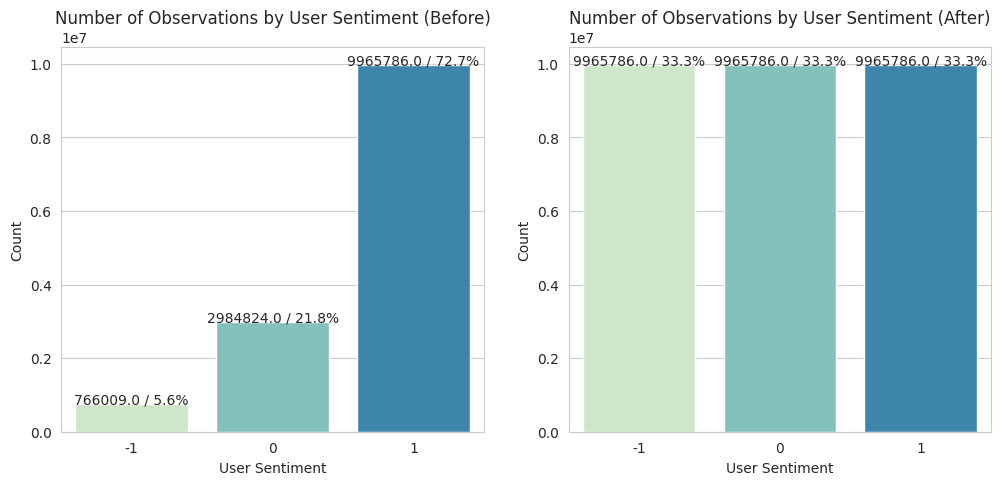

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.set_style("whitegrid")

categorical_countplot(
    data_series=y_train_backup,
    title="Number of Observations by User Sentiment (Before)",
    xlabel="User Sentiment",
    ylabel="Count",
    metric_type="both",
    display_metric_margin=100,
    axis=axis[0]
)

categorical_countplot(
    data_series=y_train_merged,
    title="Number of Observations by User Sentiment (After)",
    xlabel="User Sentiment",
    ylabel="Count",
    metric_type="both",
    display_metric_margin=100,
    axis=axis[1]
)

In [ ]:
# Function: calculate all metrics to evalue model
def evaluate_model(built_model, X_train, X_test, y_train, y_test):
    y_train_pred = built_model.predict(X_train)
    y_test_pred = built_model.predict(X_test)
    print("Report for trainning process:")
    print(classification_report(y_train.values, y_train_pred))
    print("-" * 33)
    print("Report for test process:")
    print(classification_report(y_test.values, y_test_pred))
    pass

In [ ]:
# Create and fit model
%%time
lr_model = LogisticRegression(
    random_state=17,
    max_iter=1000,
    multi_class="multinomial",
    solver="sag"
).fit(X_train_merged, y_train_merged)

CPU times: user 46min 4s, sys: 1.58 s, total: 46min 6s
Wall time: 45min 54s


In [ ]:
# Evaluate model
evaluate_model(lr_model, X_train_merged, X_test, y_train_merged, y_test)

Report for trainning process:
              precision    recall  f1-score   support

          -1       0.96      0.98      0.97   9965786
           0       0.93      0.94      0.93   9965786
           1       0.97      0.94      0.95   9965786

    accuracy                           0.95  29897358
   macro avg       0.95      0.95      0.95  29897358
weighted avg       0.95      0.95      0.95  29897358

---------------------------------
Report for test process:
              precision    recall  f1-score   support

          -1       0.63      0.80      0.71    328924
           0       0.74      0.83      0.78   1277381
           1       0.97      0.92      0.95   4272246

    accuracy                           0.89   5878551
   macro avg       0.78      0.85      0.81   5878551
weighted avg       0.90      0.89      0.90   5878551

